CCP ASSIGNMENT

Name: SHAHZAIB

Roll No: 23-AI-42

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

1. DATA PREPROCESSING

In [5]:
# Load the dataset
df = pd.read_csv('titanic.csv')

# Handle Noisy/Irrelevant Features: 
# The dataset contains many columns named 'zero' which are irrelevant.
# I also drop 'Passengerid' as it is just an index.
cols_to_drop = [col for col in df.columns if 'zero' in col] + ['Passengerid']
df_cleaned = df.drop(columns=cols_to_drop)

# Rename the target column for clarity (originally in the dataset it is '2urvived')
df_cleaned.rename(columns={'2urvived': 'Survived'}, inplace=True)

# Handle Missing Values:
# Embarked has 2 missing values; we fill them with the most common value (mode).
df_cleaned['Embarked'].fillna(df_cleaned['Embarked'].mode()[0], inplace=True)

print(f"Cleaned columns: {df_cleaned.columns.tolist()}")
print(f"Missing values remaining: {df_cleaned.isnull().sum().sum()}")

# Define Features (X) and Target (y)
X = df_cleaned.drop('Survived', axis=1)
y = df_cleaned['Survived']

# Split the data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize/Standardize features (Crucial for SVM and Naive Bayes)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data splitting and scaling complete.\n")

Cleaned columns: ['Age', 'Fare', 'Sex', 'sibsp', 'Parch', 'Pclass', 'Embarked', 'Survived']
Missing values remaining: 0
Data splitting and scaling complete.



C:\Users\Dell\AppData\Local\Temp\ipykernel_13828\1537672479.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned['Embarked'].fillna(df_cleaned['Embarked'].mode()[0], inplace=True)


2. MODEL DEVELOPMENT & CROSS-VALIDATION

In [6]:
# Initialize the three required supervised models
# We use max_depth=5 for Decision Tree as a 'Pruning' technique to prevent overfitting.
models = {
    'Decision Tree': DecisionTreeClassifier(max_depth=5, random_state=42),
    'Naïve Bayes': GaussianNB(),
    'Support Vector Machine': SVC(kernel='rbf', probability=True, random_state=42)
}

cv_results = {}
for name, model in models.items():
    # Evaluate using 5-fold cross-validation
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
    cv_results[name] = scores.mean()
    print(f"{name} CV Accuracy: {scores.mean():.4f}")


Decision Tree CV Accuracy: 0.7765
Naïve Bayes CV Accuracy: 0.7564
Support Vector Machine CV Accuracy: 0.7813


3. MODEL OPTIMIZATION & ENSEMBLE

In [7]:
# Bagging: Random Forest
# Boosting: AdaBoost
ensembles = {
    'Random Forest (Bagging)': RandomForestClassifier(n_estimators=100, random_state=42),
    'AdaBoost (Boosting)': AdaBoostClassifier(n_estimators=100, random_state=42)
}

for name, model in ensembles.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
    cv_results[name] = scores.mean()
    print(f"{name} CV Accuracy: {scores.mean():.4f}")

# Justification:
# Ensemble learning typically performs better on noisy data because:
# 1. Bagging (Random Forest) reduces variance by averaging multiple trees, smoothing out noise.
# 2. Boosting (AdaBoost) focuses on difficult-to-predict samples, potentially improving bias.


Random Forest (Bagging) CV Accuracy: 0.7669
AdaBoost (Boosting) CV Accuracy: 0.7794


4. PERFORMANCE ANALYSIS & VISUALIZATION

                  Model  Accuracy  Precision   Recall  F1-Score
          Decision Tree  0.763359   0.603774 0.438356  0.507937
            Naïve Bayes  0.717557   0.487805 0.273973  0.350877
 Support Vector Machine  0.790076   0.704545 0.424658  0.529915
Random Forest (Bagging)  0.709924   0.480000 0.493151  0.486486
    AdaBoost (Boosting)  0.801527   0.705882 0.493151  0.580645


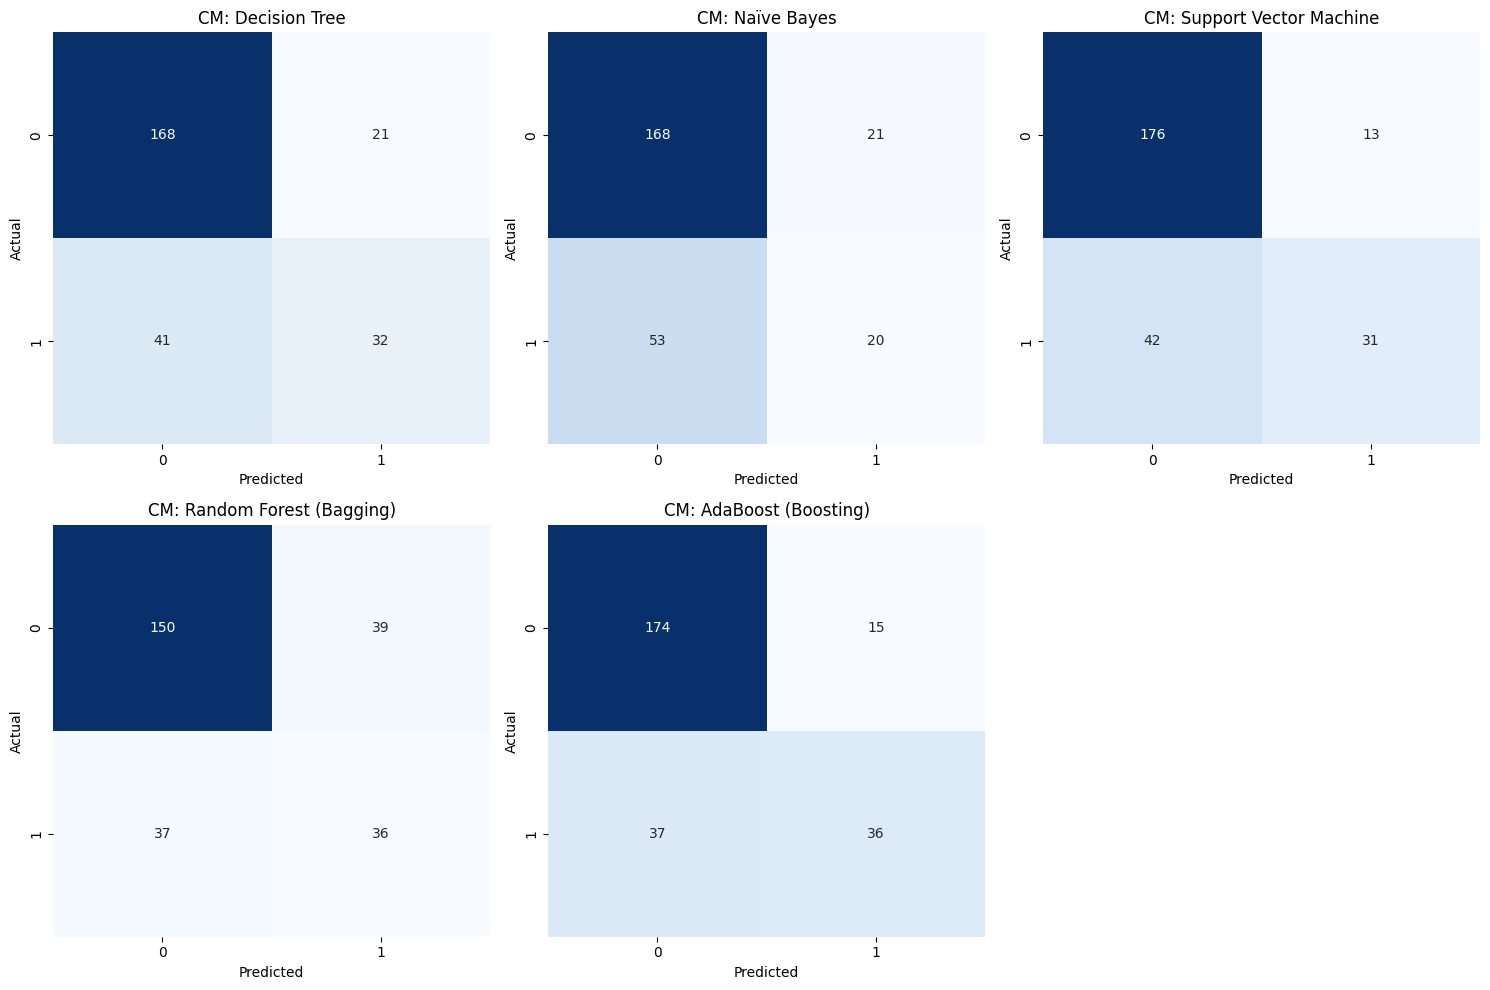


--- Impact of Overfitting & Mitigation ---
1. Overfitting: Occurs when a model (like an unpruned Decision Tree) learns noise 
   in the training data, leading to poor performance on new test data.
2. Mitigation (Pruning): In this code, we limited 'max_depth' for the Decision Tree. 
   This prevents the tree from becoming overly complex and 'memorizing' the data.
3. Mitigation (Regularization): SVM uses a 'C' parameter (default=1.0) to balance 
   the trade-off between a smooth decision boundary and classifying training points correctly.


In [8]:
all_models = {**models, **ensembles}
final_metrics = []
cms = {}

for name, model in all_models.items():
    # Fit and Predict
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    # Calculate Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    final_metrics.append({'Model': name, 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1-Score': f1})
    cms[name] = confusion_matrix(y_test, y_pred)

# Display Metrics Table
metrics_df = pd.DataFrame(final_metrics)
print(metrics_df.to_string(index=False))

# Plot Confusion Matrices
plt.figure(figsize=(15, 10))
for i, (name, cm) in enumerate(cms.items(), 1):
    plt.subplot(2, 3, i)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'CM: {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# OVERFITTING & REGULARIZATION EXPLANATION
print("\n--- Impact of Overfitting & Mitigation ---")
print("1. Overfitting: Occurs when a model (like an unpruned Decision Tree) learns noise ")
print("   in the training data, leading to poor performance on new test data.")
print("2. Mitigation (Pruning): In this code, we limited 'max_depth' for the Decision Tree. ")
print("   This prevents the tree from becoming overly complex and 'memorizing' the data.")
print("3. Mitigation (Regularization): SVM uses a 'C' parameter (default=1.0) to balance ")
print("   the trade-off between a smooth decision boundary and classifying training points correctly.")